# Calculating Climatologies and Anomalies with Xarray and Dask:

## A Workaround for a Longstanding Problem

Climatologies are anomalies are a core operation in climate science. Many workflows start with the following operations:
- Group spatiotemporal data by month or dayofyear (determined by the resolution of the dataset)
- Take a mean of each group to determine the "climatology"
- Broadcast the climatology back to the original dataset and subtract it, producing the "anomaly"

Xarray makes this easy. We often write code like

    gb = ds.groupby('time.month')
    clim = gb.mean(dim='time')
    anom = gb - clim

Unfortunately there are problems related to how dask deals with this operation 

- https://github.com/pydata/xarray/issues/1832
- https://github.com/dask/dask/issues/874
- https://github.com/pangeo-data/pangeo/issues/271

There have been many attempted fixes over the years (see linked PRs above). But none of them has been totally successful.

Here we desribe a new approach.

In [2]:
import xarray as xr
from dask.distributed import Client
import intake
import gcsfs
%matplotlib inline
xr.__version__

'0.15.1'

### The Dataset: MERRA2 Daily Surface Temprature

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(experiment_id='historical',  # pick the `historical` forcing experiment
                 table_id='day',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='tas',           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 28 group(s)
[########################################] | 100% Completed |  2.0s


In [13]:
ds = ds_dict['CMIP.AS-RCEC.TaiESM1.historical.day.gn']
ds = ds.sel(time=slice(1,5000)) 
for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)
ds = xr.decode_cf(ds)


In [15]:
ds.tas.data

dask.array<getitem, shape=(1, 5000, 192, 288), dtype=float32, chunksize=(1, 399, 192, 288), chunktype=numpy.ndarray>

### Default, No Rechunking

In [18]:
gb = ds.tas.groupby('time.dayofyear')
clim = gb.mean(dim='time')
anom = gb - clim
anom_std = anom.std(dim='time')
anom_std.data
# anom_std.tas.data

dask.array<sqrt, shape=(1, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>

In [19]:
from dask.distributed import Client
from dask_gateway import Gateway

gateway = Gateway()  # connect to Gateway
cluster = gateway.new_cluster()  # create cluster

cluster.adapt(minimum=4, maximum=40)

client = Client(cluster)  # connect Client to Cluster
client

<Client: 'tls://10.50.207.14:8786' processes=0 threads=0, memory=0 B>

We see we have balooned up to almost 100,000 tasks

In [20]:
%time anom_std.load()

CPU times: user 6.76 s, sys: 961 ms, total: 7.72 s
Wall time: 34.9 s


<xarray.DataArray 'tas' (member_id: 1, lat: 192, lon: 288)>
array([[[3.6251645, 3.6193373, 3.616409 , ..., 3.6161823, 3.622196 ,
         3.6158657],
        [3.9051728, 3.90723  , 3.908259 , ..., 3.9132876, 3.9195328,
         3.9194427],
        [4.1503   , 4.129371 , 4.1044436, ..., 4.201919 , 4.181757 ,
         4.1905837],
        ...,
        [5.0297656, 5.033636 , 5.0373616, ..., 5.020047 , 5.023476 ,
         5.026499 ],
        [4.800882 , 4.8020406, 4.803095 , ..., 4.7961397, 4.7978053,
         4.7994475],
        [4.649828 , 4.650158 , 4.65046  , ..., 4.6486306, 4.6490684,
         4.6494656]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: member_id

Two minutes is a really long time to process 12 GB of data. And the dask cluster almost choked in the process.

The parallelism became too fine-grained, resulting in too much communication overhead.

### With Rechunking

Since the operation is embarassingly parallel in the space dimension, but the data are chunked in the time dimension, one idea is that rechunking could help.

In [21]:
ds_rechunk = ds.chunk({'time': -1, 'lat': 3})
ds_rechunk.tas.data

dask.array<rechunk-merge, shape=(1, 5000, 192, 288), dtype=float32, chunksize=(1, 5000, 3, 288), chunktype=numpy.ndarray>

In [23]:
gb = ds_rechunk.groupby('time.dayofyear')
clim = gb.mean(dim='time')
anom = gb - clim
anom_std = anom.std(dim='time')
anom_std.tas.data

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]


dask.array<sqrt, shape=(1, 192, 288), dtype=float32, chunksize=(1, 3, 288), chunktype=numpy.ndarray>

This created **4.5 million tasks**! Clearly not the solution we were hoping for. I'm not even going to try to compute it. For whatever reason, the way these operation (mostly indexing and broadcasting) are interpreted by dask array does not allow them to leverage the parallelism we know is possible.

### The Workaround: `Xarray.map_blocks`

Since the computation is embarassingly parallel in the space dimension, I could use `dask.array.map_blocks` to operate on each chunk in isolation. The problem is, I don't know how to write the groupby and broadcasting logic in pure numpy. I need xarray and its indexes.

The solution is xarray's new `map_blocks` function.

In [24]:
def calculate_anomaly(ds):
    # needed to workaround xarray's check with zero dimensions
    # https://github.com/pydata/xarray/issues/3575
    if len(ds['time']) == 0:
        return ds
    gb = ds.groupby("time.month")
    clim = gb.mean(dim='time')
    return gb - clim

In [25]:
t2mmax_anom = xr.map_blocks(calculate_anomaly, ds_rechunk.tas)
t2mmax_anom.data

dask.array<calculate_anomaly-2eaa2b5bc86469462cd3b5a53a3578af-<this, shape=(1, 5000, 192, 288), dtype=float32, chunksize=(1, 5000, 3, 288), chunktype=numpy.ndarray>

That seems great! Only 300 chunks! Let's see how it performs.

In [26]:
%time t2mmax_std = t2mmax_anom.std(dim='time').load()

CPU times: user 884 ms, sys: 30.7 ms, total: 915 ms
Wall time: 12.9 s


This was about twice as fast. Moreover, it feels like a more scalable approach.

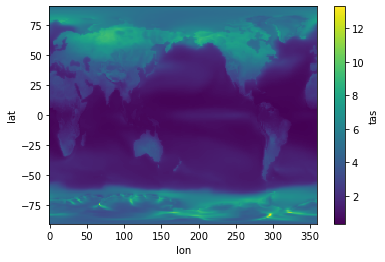

In [27]:
t2mmax_std.plot()

## Compute the climatology and anomalies as 2D maps

The advantage of the `map_blocks` approach is that it doesn't create too many chuncks. That way we can lazily build more operations on top of the anomaly dataset.

Below we count the number of "hot events" (anomaly > 1 degree for two consecutive days) per year.

In [28]:
rolling = t2mmax_anom.rolling(time = 2, center = True)
rolling_hot = rolling.max()
rolling_hot

<xarray.DataArray (member_id: 1, time: 5000, lat: 192, lon: 288)>
dask.array<where, shape=(1, 5000, 192, 288), dtype=float32, chunksize=(1, 4999, 3, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-02 12:00:00 ... 1863-09-13 12:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: member_id

In [55]:
yearly_events = (rolling_hot > 1).astype('int').resample(time='YS').sum()
yearly_events.data

dask.array<transpose, shape=(1, 14, 192, 288), dtype=int64, chunksize=(1, 1, 3, 288), chunktype=numpy.ndarray>

In [56]:
yearly_events.load()

<xarray.DataArray (member_id: 1, time: 14, lat: 192, lon: 288)>
array([[[[172, 172, 172, ..., 172, 172, 172],
         [176, 176, 177, ..., 177, 172, 172],
         [175, 181, 180, ..., 182, 181, 183],
         ...,
         [230, 231, 232, ..., 233, 232, 230],
         [226, 226, 226, ..., 226, 226, 226],
         [236, 236, 236, ..., 236, 236, 236]],

        [[138, 139, 137, ..., 137, 138, 137],
         [140, 140, 139, ..., 141, 140, 142],
         [150, 149, 149, ..., 148, 151, 149],
         ...,
         [199, 198, 197, ..., 201, 201, 199],
         [199, 199, 201, ..., 203, 202, 201],
         [222, 222, 222, ..., 222, 222, 222]],

        [[155, 156, 157, ..., 157, 156, 156],
         [157, 157, 157, ..., 157, 156, 155],
         [145, 143, 142, ..., 146, 146, 145],
         ...,
         [250, 251, 251, ..., 251, 253, 252],
         [245, 243, 243, ..., 245, 245, 245],
         [239, 239, 239, ..., 239, 239, 239]],

        ...,

        [[146, 146, 146, ..., 146, 146, 146],
         [144, 144, 141, ..., 142, 140, 141],
         [150, 150, 147, ..., 148, 147, 144],
         ...,
         [213, 213, 213, ..., 214, 215, 216],
         [204, 204, 204, ..., 202, 203, 203],
         [208, 208, 208, ..., 210, 208, 208]],

        [[143, 143, 143, ..., 143, 143, 143],
         [148, 148, 148, ..., 144, 146, 148],
         [148, 149, 148, ..., 150, 147, 147],
         ...,
         [128, 128, 127, ..., 130, 129, 130],
         [122, 122, 122, ..., 127, 123, 122],
         [140, 140, 140, ..., 140, 140, 140]],

        [[126, 124, 124, ..., 126, 126, 124],
         [126, 126, 126, ..., 129, 129, 128],
         [124, 124, 122, ..., 121, 123, 125],
         ...,
         [156, 156, 157, ..., 156, 156, 157],
         [160, 159, 158, ..., 161, 160, 160],
         [154, 154, 154, ..., 154, 154, 154]]]])
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 1863-01-01 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: member_id

In [57]:
yearly_events

<xarray.DataArray (member_id: 1, time: 14, lat: 192, lon: 288)>
array([[[[172, 172, 172, ..., 172, 172, 172],
         [176, 176, 177, ..., 177, 172, 172],
         [175, 181, 180, ..., 182, 181, 183],
         ...,
         [230, 231, 232, ..., 233, 232, 230],
         [226, 226, 226, ..., 226, 226, 226],
         [236, 236, 236, ..., 236, 236, 236]],

        [[138, 139, 137, ..., 137, 138, 137],
         [140, 140, 139, ..., 141, 140, 142],
         [150, 149, 149, ..., 148, 151, 149],
         ...,
         [199, 198, 197, ..., 201, 201, 199],
         [199, 199, 201, ..., 203, 202, 201],
         [222, 222, 222, ..., 222, 222, 222]],

        [[155, 156, 157, ..., 157, 156, 156],
         [157, 157, 157, ..., 157, 156, 155],
         [145, 143, 142, ..., 146, 146, 145],
         ...,
         [250, 251, 251, ..., 251, 253, 252],
         [245, 243, 243, ..., 245, 245, 245],
         [239, 239, 239, ..., 239, 239, 239]],

        ...,

        [[146, 146, 146, ..., 146, 146, 146],
         [144, 144, 141, ..., 142, 140, 141],
         [150, 150, 147, ..., 148, 147, 144],
         ...,
         [213, 213, 213, ..., 214, 215, 216],
         [204, 204, 204, ..., 202, 203, 203],
         [208, 208, 208, ..., 210, 208, 208]],

        [[143, 143, 143, ..., 143, 143, 143],
         [148, 148, 148, ..., 144, 146, 148],
         [148, 149, 148, ..., 150, 147, 147],
         ...,
         [128, 128, 127, ..., 130, 129, 130],
         [122, 122, 122, ..., 127, 123, 122],
         [140, 140, 140, ..., 140, 140, 140]],

        [[126, 124, 124, ..., 126, 126, 124],
         [126, 126, 126, ..., 129, 129, 128],
         [124, 124, 122, ..., 121, 123, 125],
         ...,
         [156, 156, 157, ..., 156, 156, 157],
         [160, 159, 158, ..., 161, 160, 160],
         [154, 154, 154, ..., 154, 154, 154]]]])
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 1863-01-01 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: member_id

In [58]:
# skip 2019
yearly_events_mean = yearly_events.mean(dim='time')
yearly_events_anom = yearly_events - yearly_events_mean

In [63]:
yearly_events_anom

<xarray.DataArray (member_id: 1, time: 14, lat: 192, lon: 288)>
array([[[[ 13.        ,  12.92857143,  13.        , ...,  12.78571429,
           12.92857143,  13.07142857],
         [ 13.21428571,  13.07142857,  14.42857143, ...,  14.92857143,
           10.14285714,   9.64285714],
         [ 16.21428571,  21.35714286,  20.5       , ...,  23.5       ,
           21.92857143,  24.14285714],
         ...,
         [ 43.85714286,  45.42857143,  46.14285714, ...,  46.35714286,
           45.42857143,  43.85714286],
         [ 39.85714286,  40.07142857,  40.        , ...,  39.85714286,
           39.71428571,  39.85714286],
         [ 45.64285714,  45.71428571,  45.71428571, ...,  45.64285714,
           45.71428571,  45.64285714]],

        [[-21.        , -20.07142857, -22.        , ..., -22.21428571,
          -21.07142857, -21.92857143],
         [-22.78571429, -22.92857143, -23.57142857, ..., -21.07142857,
          -21.85714286, -20.35714286],
         [ -8.78571429, -10.64285714, -10.5       , ..., -10.5       ,
           -8.07142857,  -9.85714286],
         ...,
         [ 12.85714286,  12.42857143,  11.14285714, ...,  14.35714286,
           14.42857143,  12.85714286],
         [ 12.85714286,  13.07142857,  15.        , ...,  16.85714286,
           15.71428571,  14.85714286],
         [ 31.64285714,  31.71428571,  31.71428571, ...,  31.64285714,
           31.71428571,  31.64285714]],

        [[ -4.        ,  -3.07142857,  -2.        , ...,  -2.21428571,
           -3.07142857,  -2.92857143],
         [ -5.78571429,  -5.92857143,  -5.57142857, ...,  -5.07142857,
           -5.85714286,  -7.35714286],
         [-13.78571429, -16.64285714, -17.5       , ..., -12.5       ,
          -13.07142857, -13.85714286],
         ...,
         [ 63.85714286,  65.42857143,  65.14285714, ...,  64.35714286,
           66.42857143,  65.85714286],
         [ 58.85714286,  57.07142857,  57.        , ...,  58.85714286,
           58.71428571,  58.85714286],
         [ 48.64285714,  48.71428571,  48.71428571, ...,  48.64285714,
           48.71428571,  48.64285714]],

        ...,

        [[-13.        , -13.07142857, -13.        , ..., -13.21428571,
          -13.07142857, -12.92857143],
         [-18.78571429, -18.92857143, -21.57142857, ..., -20.07142857,
          -21.85714286, -21.35714286],
         [ -8.78571429,  -9.64285714, -12.5       , ..., -10.5       ,
          -12.07142857, -14.85714286],
         ...,
         [ 26.85714286,  27.42857143,  27.14285714, ...,  27.35714286,
           28.42857143,  29.85714286],
         [ 17.85714286,  18.07142857,  18.        , ...,  15.85714286,
           16.71428571,  16.85714286],
         [ 17.64285714,  17.71428571,  17.71428571, ...,  19.64285714,
           17.71428571,  17.64285714]],

        [[-16.        , -16.07142857, -16.        , ..., -16.21428571,
          -16.07142857, -15.92857143],
         [-14.78571429, -14.92857143, -14.57142857, ..., -18.07142857,
          -15.85714286, -14.35714286],
         [-10.78571429, -10.64285714, -11.5       , ...,  -8.5       ,
          -12.07142857, -11.85714286],
         ...,
         [-58.14285714, -57.57142857, -58.85714286, ..., -56.64285714,
          -57.57142857, -56.14285714],
         [-64.14285714, -63.92857143, -64.        , ..., -59.14285714,
          -63.28571429, -64.14285714],
         [-50.35714286, -50.28571429, -50.28571429, ..., -50.35714286,
          -50.28571429, -50.35714286]],

        [[-33.        , -35.07142857, -35.        , ..., -33.21428571,
          -33.07142857, -34.92857143],
         [-36.78571429, -36.92857143, -36.57142857, ..., -33.07142857,
          -32.85714286, -34.35714286],
         [-34.78571429, -35.64285714, -37.5       , ..., -37.5       ,
          -36.07142857, -33.85714286],
         ...,
         [-30.14285714, -29.57142857, -28.85714286, ..., -30.64285714,
          -30.57142857, -29.14285714],
         [-26.14285714, -26.92857143, -28.        , ..., -25.14285714,
          -26.285

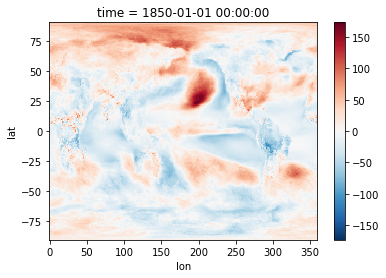

In [64]:
yearly_events_anom[0,0,:,:].plot()

In [34]:
yearly_events_anom[-1].plot()

IndexError: index -1 is out of bounds for axis 0 with size 0